## Additional Modeling using Neural Network.  

It is a common approach for small amount of data, such as this homework, the data scientis would use traditional modeling techniques, such as SVM, ensemble learning algorithm or tree based algorithm. And leave neural network out of discussion. 

As short of learning samples, would make neural network harder to generalise and tuning parameters. 

But there are cerain good properties in Neural Network, such as auto feature engineering, ability to scope to larger dataset, would still make it a valid candidate to build a baseline model. 

In this code, I would use keras as the deep learning framework. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

from keras import Sequential 
from keras.layers import Dense,Input,Dropout,BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from tqdm.notebook import tqdm
tqdm.pandas()


In [2]:
## Common methods to load and preprocess data
def load_data(filepath):
    
    columns = ['index','age','breed','last_vet_visit','hair_length','height','num_vet_visit','weight']
    
    return pd.read_csv(filepath,names=columns,header=0)

def remove_negative_value(df, columns):
    # df: dataframe of the data 
    # columns: list of columns need to remove negative value from 
    
    if len(columns) == 0 and df.empty:
        return df
    
    for col in columns:
        df = df[df[col]>=0]
    
    return df


def remove_extreme_outliers(df,columns):
    #for values great then quantile 99.9% then it would be treated as exterm outlier 
    # df: dataframe of the data 
    # columns: list of columns need to remove negative value from 
    
    if len(columns) == 0 and df.empty:
        return df
    
    for col in columns:
        limit = df[col].quantile(0.999)
        df = df[df[col]<limit] 
        
    return df

# Create a data pipeline to handle Category and scale numerical data

category_cols = ['breed']
numerical_cols = ['hair_length','height','num_vet_visit','weight']

pipeline = make_pipeline(
    ColumnTransformer([
        ('num', StandardScaler(),numerical_cols),
        ('cat',OneHotEncoder(handle_unknown='ignore'),category_cols),
        
    ],remainder='passthrough')
)

def preprocess():
    
    filepath='data.csv'

    df = load_data(filepath)

    #remove  column 
    df = df.drop(columns=['index','last_vet_visit'])

    #remove any negative value
    df = remove_negative_value(df,['age','hair_length','height','num_vet_visit','weight'])

    #remove any exterme outliers
    df = remove_extreme_outliers(df,['age','hair_length','height','num_vet_visit','weight'])
 
    #split training, test and validation set
    val_size = 0.2 
    test_size = 0.15
    
    df_temp,df_test = train_test_split(df, test_size=test_size,random_state=1)
    df_train,df_val = train_test_split(df_temp, test_size=val_size,random_state=1)
    
#     print(df_train.head())
    #using the pipeline to scale numerical column and onehot encoder for category column
    df_train = pipeline.fit_transform(df_train)
    df_test = pipeline.transform(df_test)
    df_val = pipeline.transform(df_val)
    
    
    return df_train,df_test,df_val

In [3]:
train,test,val=preprocess()
print('train size {}, test size {}, validation size {}'.format(train.shape,test.shape,val.shape))

train size (196, 11), test size (44, 11), validation size (50, 11)


In [7]:
def split_x_y(dataset):
    return dataset[:,:-1],dataset[:,-1]

In [8]:
x_train,y_train = split_x_y(train)
x_test,y_test = split_x_y(test)
x_val,y_val = split_x_y(val)

In [11]:
# evaluate overall model performance

def evaluation(model,benchmark_score):
    score = model.evaluate(x_test, y_test, verbose=2)
    
    if score < benchmark_score:
        print('The current score:{} BEATS the bechmark score {}'.format(score,benchmark_score))
        benchmark_score = score
    else:
        print('The current score:{} is NO BETTER the bechmark score {}'.format(score,benchmark_score))
        
    return benchmark_score
        
benchmark_score = 999

In [50]:
def model_def(input_shape):
    inputs = Input(shape=(input_shape,),name='input')
    hidden1 = Dense(20,activation='relu',name='hidden1')(inputs)
    hidden2 = Dense(20,activation='relu',name='hidden2')(hidden1)
#     hidden3 = Dense(30,activation='relu',name='hidden3')(hidden2)
    outputs = Dense(1,activation='linear',name='output')(hidden2)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [51]:
model= model_def(x_train.shape[1])
model.compile(optimizer ='adam',
              loss='mean_squared_error')
model.summary()
model.fit(x_train,y_train,batch_size=30, epochs=200,verbose=0)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
hidden1 (Dense)              (None, 20)                220       
_________________________________________________________________
hidden2 (Dense)              (None, 20)                420       
_________________________________________________________________
output (Dense)               (None, 1)                 21        
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________


In [52]:
benchmark_score = evaluation(model,benchmark_score)

2/2 - 0s - loss: 10.4360
The current score:10.43604564666748 is NO BETTER the bechmark score 9.714255332946777


In [14]:
history=model.fit(x_train,y_train, batch_size=30, epochs=100,verbose=0) 

test_scores = model.evaluate(x_test, y_test, verbose=2)

print("Test loss:", test_scores)

2/2 - 0s - loss: 10.3540
Test loss: 10.354048728942871


In [15]:
def plot_training_history_1(history):
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.gca().set_ylim(0,100)
    plt.gca().set_xlim(0,len(history.history['loss']))
    plt.show()

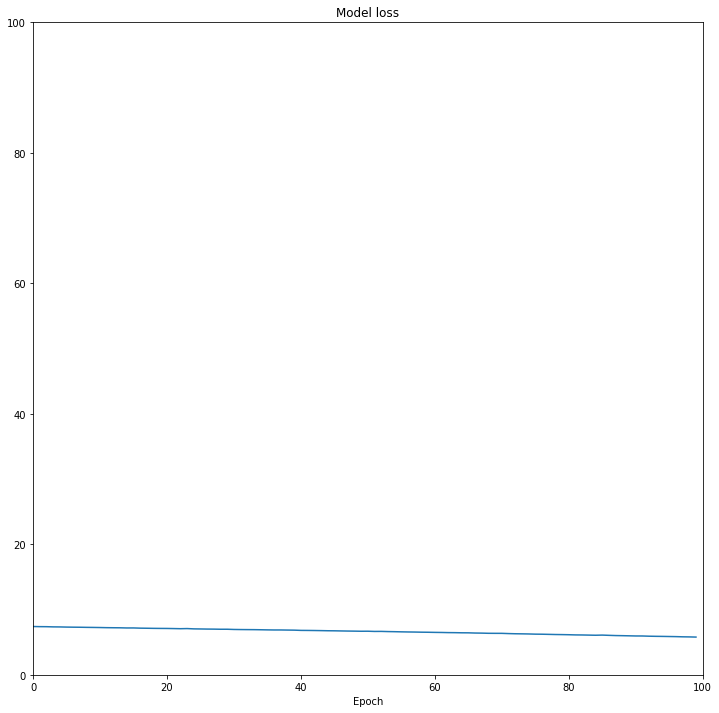

In [16]:
plot_training_history_1(history)